In [1]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import os
import sys

import torch
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2
from einops import rearrange

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# local imports
root_dir = os.path.abspath(os.path.join('..', '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)

from data_modules import cityscapes, urbansyn
import utils
from urbansyn_segformer import UrbanSynSegFormer

In [2]:
cs = cityscapes.CityscapesDownloader(os.path.join(root_dir, 'data'))
us = urbansyn.UrbanSynDownloader(os.path.join(root_dir, 'data'))
BATCH_SIZE = 8

dm = cs.get_datamodule(batch_size=BATCH_SIZE)

torch.Size([8, 3, 512, 1024]) torch.Size([8, 512, 1024])


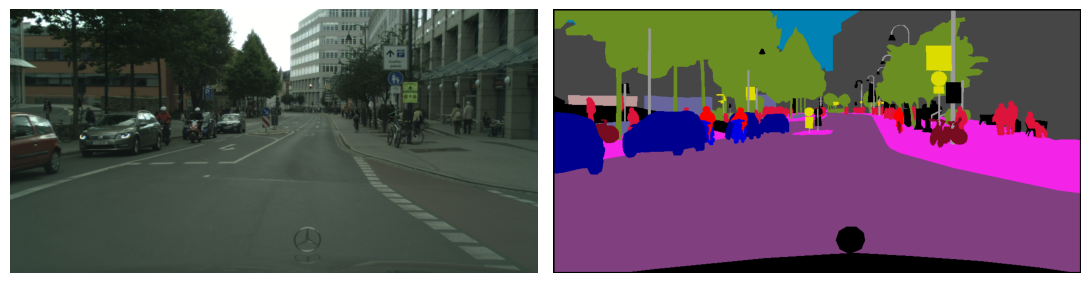

In [14]:
datamodule = cs.get_datamodule(batch_size=BATCH_SIZE, downscaling=2)
datamodule.setup('fit')
for x, y in datamodule.train_dataloader():
    print(x.size(), y.size())
    fig,ax = plt.subplots(1, 2, figsize=(11,3))
    ax[0].imshow(rearrange(cityscapes.INV_NORMALIZE(x[0]), 'c h w -> h w c'))
    ax[0].axis('off')
    ax[1].imshow(cityscapes.colorize_segmap(y, for_pil=True)[0])
    ax[1].axis('off')
    plt.tight_layout()
    # plt.savefig('../../img/cityscapes_example.png')
    plt.show()
    break

In [3]:
exp_path = os.path.join(root_dir, 'experiments', 'urbansyn_segformer')

LOAD_FINETUNED = True

if LOAD_FINETUNED:
    lightning_model = UrbanSynSegFormer.load_from_checkpoint(os.path.join(exp_path, 'best.ckpt'))
else:
    lightning_model = UrbanSynSegFormer(learning_rate=1e-4, lr_gamma=0.99)

trainer =  Trainer(limit_predict_batches=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.


In [6]:
datamodule = cs.get_datamodule(batch_size=16, downscaling=2)
validation = trainer.validate(lightning_model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\main\repos\computer-vision\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        _MeanIoU_           0.6982153654098511
       bicycle_IoU          0.6659281849861145
      building_IoU          0.8974660038948059
         bus_IoU            0.7579551935195923
         car_IoU            0.9095324873924255
        fence_IoU           0.4981471598148346
     motorcycle_IoU         0.5347609519958496
       person_IoU           0.7013013362884521
        pole_IoU            0.47841745615005493
        rider_IoU           0.4718501567840576
        road_IoU             0.97281813621521
      sidewalk_IoU          0.7949127554893494
         sky_IoU            0.9252306222915649
       terrain_IoU          0.6195911169052124
    traffic_light_IoU       0.5408375263214111
    traff

In [4]:
datamodule = us.get_datamodule(batch_size=16, downscaling=2)
validation = trainer.validate(lightning_model, datamodule=datamodule)

You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\main\repos\computer-vision\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        _MeanIoU_           0.6165197491645813
        accuracy            0.9289354681968689
       bicycle_IoU          0.5134806632995605
      building_IoU          0.8803015947341919
         bus_IoU             0.685682475566864
         car_IoU            0.8642052412033081
        fence_IoU           0.5061076283454895
     motorcycle_IoU         0.40058043599128723
       person_IoU           0.6775013208389282
        pole_IoU            0.4687785506248474
        rider_IoU           0.33594080805778503
        road_IoU            0.9596452713012695
      sidewalk_IoU          0.7806146740913391
         sky_IoU            0.8403222560882568
       terrain_IoU          0.3681371510028839
    tra

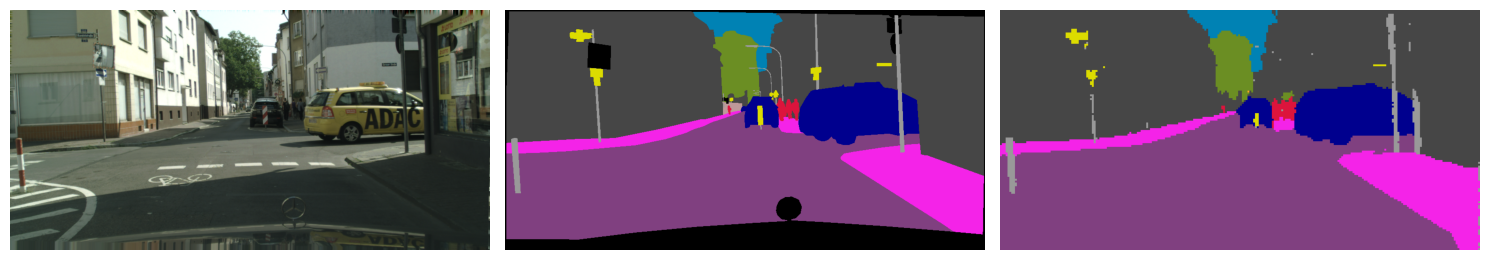

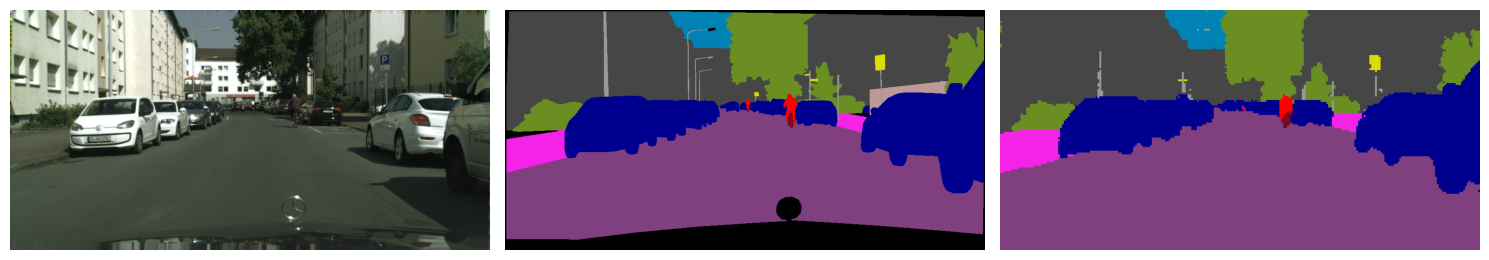

In [24]:
num_images = 2

datamodule = cs.get_datamodule(batch_size=num_images, downscaling=1)
datamodule.setup('val')

index = 0
x, target = next(batch for i,batch in enumerate(iter(datamodule.val_dataloader())) if i==index)

#output = trainer.predict(lightning_model, datamodule=datamodule)[0].detach().cpu()
lightning_model.eval()
output = lightning_model(x.to(lightning_model.device)).detach().cpu()

segmaps = cityscapes.colorize_segmap(torch.argmax(output, 1), for_pil=True)
true_segmaps = cityscapes.colorize_segmap(target, for_pil=True)

for image, true_segmap, segmap in zip(x, true_segmaps, segmaps):
    fig,ax = plt.subplots(1, 3, figsize=(15,3))
    ax[0].imshow(rearrange(cityscapes.INV_NORMALIZE(image), 'c h w -> h w c'))
    ax[0].axis('off')
    ax[1].imshow(true_segmap)
    ax[1].axis('off')
    ax[2].imshow(segmap)
    ax[2].axis('off')
    plt.tight_layout()
    plt.show()

In [25]:
metric = MeanIoU(20, include_background=False, per_class=False)
metric(output, target)

tensor(0.3665)

In [26]:
metric = MeanIoU(20, include_background=False, per_class=True)
values = metric(output, target)
zeros = []
for c,v in zip(cityscapes.CLASS_NAMES[1:], values):
    print(f'{c}: {v.item()*100:.1f}%')
    if v==0:
        zeros.append(c)

print(zeros)

road: 76.9%
sidewalk: 83.0%
building: 89.7%
wall: 0.0%
fence: 0.7%
pole: 34.3%
traffic_light: 0.0%
traffic_sign: 54.0%
vegetation: 88.3%
terrain: 0.0%
sky: 86.0%
person: 35.4%
rider: 29.6%
car: 93.3%
truck: 0.0%
bus: 0.0%
train: 0.0%
motorcycle: 0.0%
bicycle: 25.2%
['wall', 'traffic_light', 'terrain', 'truck', 'bus', 'train', 'motorcycle']


In [59]:
def get_intersections_and_unions(predictions, targets, ignore_background=True):
    """Calculates intersections and unions of predicted and target segmentation
    maps for each class

    Args:
        predictions (torch.Tensor): prediction logits of shape (B, C, H, W)
        targets (torch.Tensor): segmentation map with class indices, (B, H, W)
        ignore_background (bool): If True, the first class is considered to be
            background and pixels marked as background in the targets are masked
            out of the calculation. Defaults to True.

    Returns:
        torch.Tensor, torch.Tensor: intersections and unions for each class.
            Shapes (C-1) if ignore_background is true, and (C) otherwise
    """
    num_classes = predictions.size()[1]
    predictions = torch.argmax(predictions, dim=1)  # from logits to class indices
    predictions = F.one_hot(predictions, num_classes=num_classes)  # from indices to one_hot (B, H, W, C)
    targets = F.one_hot(targets, num_classes=num_classes)  # from indices to one_hot (B, H, W, C)

    reduce_axis = [0, 1, 2]
    if ignore_background:
        intersection = torch.sum(predictions & targets, dim=reduce_axis)[1:]
        mask = ~targets[..., :1].repeat(1, 1, 1, num_classes).to(torch.bool)
        union = torch.sum(predictions*mask | targets*mask, dim=reduce_axis)[1:]
        return intersection, union
    else:
        intersection = torch.sum(predictions & targets, dim=reduce_axis)
        union = torch.sum(predictions | targets, dim=reduce_axis)
        return intersection, union

In [64]:
targets = torch.randint(0, 3, (2, 5 ,5))
targets_wo_bkg = torch.clone(targets)
targets_wo_bkg[targets==0] = 1

predictions = F.one_hot(targets_wo_bkg, 3).movedim(-1, 1) + 0.5
predictions[:, 2] += 2
print(targets[0])
print(torch.argmax(predictions, dim=1)[0])
i, u = get_intersections_and_unions(predictions, targets, True)
print(i, u)

tensor([[0, 0, 0, 2, 0],
        [1, 2, 1, 2, 2],
        [1, 1, 0, 0, 2],
        [0, 2, 2, 0, 0],
        [1, 2, 1, 0, 0]])
tensor([[2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2]])
tensor([ 0, 16]) tensor([14, 30])
